In [447]:
import pandas as pd

train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
Id = test_df['PassengerId']

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [448]:
ntrain = train_df.shape[0]
Y = train_df['Survived']
all_data = pd.concat([train_df,test_df],axis=0)
all_data.drop(['Survived'],axis=1,inplace=True)
all_data.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [449]:
all_data.drop(['Name','Ticket','PassengerId'],axis=1,inplace=True)
m_age = all_data['Age'].mean()
all_data['Age'] = all_data['Age'].fillna(m_age)
all_data['Cabin'] = all_data['Cabin'].fillna('None')
all_data['Cabin'] = all_data['Cabin'].astype(str)
all_data['Cabin'] = all_data['Cabin'].apply(lambda x: x[0])
mod_emb = all_data['Embarked'].mode()
all_data['Embarked'] = all_data['Embarked'].fillna(mod_emb)
mean_fare = all_data['Fare'].mean()
all_data['Fare'] = all_data['Fare'].fillna(mean_fare)
train_df['Cabin'] = train_df['Cabin'].fillna('None')
train_df['Cabin'] = train_df['Cabin'].astype(str)
train_df['Cabin'] = train_df['Cabin'].apply(lambda x: x[0])



<BarContainer object of 7 artists>

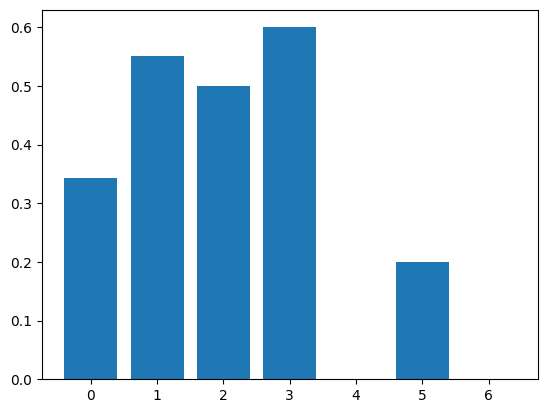

In [450]:
import matplotlib.pyplot as plt

cnts = train_df.groupby('Parch')['Survived'].apply(lambda x: (x == 1).sum() / len(x))
plt.bar(cnts.index,cnts.values)

In [451]:
categorical = ['Pclass','SibSp','Parch']
for col in categorical:
    all_data[col] = all_data[col].astype('object')

object_columns = all_data.select_dtypes(include=['object']).columns

for col in object_columns:
    all_data[col],unique = pd.factorize(all_data[col])

# all_data[object_columns] = all_data[object_columns].astype('category')
# all_data = pd.concat([all_data.drop(object_columns, axis=1), pd.get_dummies(all_data[object_columns])], axis=1)
    
all_data.head(5)


,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,0,22.0,0,0,7.2500,0,0
1,1,1,38.0,0,0,71.2833,1,1
2,0,1,26.0,1,0,7.9250,0,0
3,1,1,35.0,0,0,53.1000,1,0
4,0,0,35.0,1,0,8.0500,0,0


In [452]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(all_data[:ntrain], Y, test_size=0.001, random_state=42)
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    learning_rate=0.01,
    n_estimators=20000,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.3,
    gamma=0,
    random_state=42
)

model.fit(X_train, y_train)

predictions = model.predict(all_data[ntrain:])
results = pd.DataFrame()
results['PassengerId'] = Id
results['Survived'] = predictions
results.to_csv('./data/result.csv',index=False)

# accuracy = accuracy_score(y_test, predictions)
# print(f"Accuracy: {accuracy}")

In [453]:
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# from sklearn.ensemble import RandomForestClassifier

# X_train, X_test, y_train, y_test = train_test_split(all_data[:ntrain], Y, test_size=0.1, random_state=42)


# random_forest = RandomForestClassifier(
#     n_estimators=10,  # Number of trees in the forest
#     criterion='gini',  # Split criterion: 'gini' or 'entropy'
#     max_depth=15,  # Maximum depth of the trees
#     min_samples_split=2,  # Minimum number of samples required to split an internal node
#     min_samples_leaf=1,  # Minimum number of samples required to be at a leaf node
#     random_state=42  # Seed for random number generation (for reproducibility)
# )

# random_forest.fit(X_train, y_train)

# predictions = random_forest.predict(X_test)
# # results = pd.DataFrame()
# # results['PassengerId'] = Id
# # results['Survived'] = predictions
# # results.to_csv('./data/result.csv',index=False)

# accuracy = accuracy_score(y_test, predictions)
# print(f"Accuracy: {accuracy}")